# K-Means Clustering

## K-Means from scratch

In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import math

In [88]:
class KMeans:
    
    def __init__(self, k, max_iter=100, tol=1e-4, init_method='random', eval=['inertia', 'silhouette', 'gap_statistic']):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.init_method = init_method
        self.eval = eval
        self.centroids = None
        self.labels = None
        self.inertia = None
        self.silhouette = None
        self.gap_statistic = None

    def fit(self, X):
        self.centroids = self._initialize_centroids(X, 'kmeans++')
        for round in range(self.max_iter):
            # Update centroids & labels
            self._update_labels(X)
            previous_centroids = self.centroids.copy() ## deep copy used here, otherwise the centroids will be updated in place
            self._update_centroids(X)
            
            optimal = True
            for i in range(self.k):
                if self._euclidean_distance(self.centroids[i], previous_centroids[i]) > self.tol:
                    optimal = False
                    break
            if optimal:
                # print(f"Converged in {round} rounds")
                break
            
        # Calculate evaluation metrics
        if 'inertia' in self.eval:
            self.inertia = self._calculate_inertia(X)
        if 'silhouette' in self.eval:
            self.silhouette = self._calculate_silhouette(X)
        if 'gap_statistic' in self.eval:
            self.gap_statistic = self._calculate_gap_statistic(X)
        
        return self.centroids, self.labels, [self.inertia, self.silhouette, self.gap_statistic]
            
    def _euclidean_distance(self, x, y):
        return np.linalg.norm(x - y)
    
    def _initialize_centroids(self, X, init_method):
        # Initialize centroids randomly
        if init_method == 'random':
            return X[np.random.choice(X.shape[0], self.k, replace=False)]
        elif init_method == 'firstk':
            return X[:self.k]
        elif init_method == 'kmeans++':
            # Initialize first centroid randomly
            centroids = [X[np.random.choice(X.shape[0])]]
            
            # Add remaining centroids
            for _ in range(1, self.k):
                # Calculate squared distances to nearest centroid for each point
                
                distances = np.array([min([self._euclidean_distance(x, c) for c in centroids]) for x in X])
                
                # Calculate probabilities proportional to squared distances
                probs = distances / distances.sum()
                
                # Choose next centroid randomly according to the probabilities
                next_centroid = X[np.random.choice(len(X), p=probs)]
                centroids.append(next_centroid)
                
            return np.array(centroids)
    
    def _update_labels(self, X):
        """Update labels based on current centroids"""
        self.labels = np.array([np.argmin([self._euclidean_distance(x, c) for c in self.centroids]) for x in X])

    def _update_centroids(self, X):
        """Update centroids based on current labels"""
        for i in range(self.k):
            self.centroids[i] = np.mean(X[self.labels == i], axis=0)

    def _calculate_inertia(self, X):
        """Calculate sum of squared distances of samples to their closest centroid"""
        return np.sum([np.sum((X[self.labels == i] - self.centroids[i]) ** 2) 
                      for i in range(self.k)])
    
    def _calculate_silhouette(self, X):
        """Calculate mean silhouette coefficient of all samples"""
        if len(np.unique(self.labels)) <= 1:
            return 0
        
        n_samples = X.shape[0]
        silhouette_vals = np.zeros(n_samples)
        
        for i in range(n_samples):
            # Calculate a (mean distance to points in same cluster)
            a = np.mean(np.linalg.norm(X[i] - X[self.labels == self.labels[i]], axis=1))
            
            # Calculate b (mean distance to points in next nearest cluster)
            b = float('inf')
            for cluster in range(self.k):
                if cluster != self.labels[i]:
                    curr_b = np.mean(np.linalg.norm(X[i] - X[self.labels == cluster], axis=1))
                    b = min(b, curr_b)
            
            silhouette_vals[i] = (b - a) / max(a, b)
            
        return np.mean(silhouette_vals)
    
    def _calculate_gap_statistic(self, X):
        """Calculate gap statistic for current clustering"""
        # Generate reference datasets
        n_refs = 5
        ref_dispersions = np.zeros(n_refs)
        
        for i in range(n_refs):
            # Create random uniform reference dataset
            ref_min = X.min(axis=0)
            ref_max = X.max(axis=0)
            ref_data = np.random.uniform(ref_min, ref_max, X.shape)
            
            # Cluster reference dataset
            ref_kmeans = KMeans(self.k, eval=['inertia'])
            ref_kmeans.fit(ref_data)
            ref_dispersions[i] = np.log(ref_kmeans.inertia)
        
        # Calculate gap statistic
        gap = np.mean(ref_dispersions) - np.log(self.inertia)
        return gap


Function notes:
1. np.random.choice(a_array, size, replace, p)
    - a_array: ndarray, array of values to choose from
    - size: int or tuple of ints, number of samples to draw
    - replace: bool, whether the values are allowed to be selected more than once
    - p: 1-D array, probability of each element being chosen


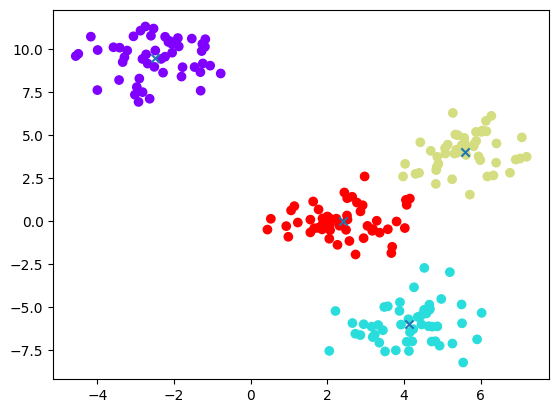

In [90]:
# Experiment with synthetic data
from sklearn.datasets import make_blobs

n = 200 # number of data points
k = 4 # number of 'blobs'
X, y = make_blobs(n_samples=n, n_features=2, random_state=109, centers=k)

# plt.scatter(X[:,0], X[:,1], c=y)
# plt.xlabel('x1')
# plt.ylabel('x2')
# plt.show()

k_means = KMeans(4, eval=[])
centroids, labels, scores = k_means.fit(X)

plt.scatter(X[:,0], X[:,1], c=labels, cmap='rainbow')
plt.scatter(centroids[:,0], centroids[:,1], marker='x')
plt.show()

Text(0.5, 1.0, 'Gap Statistic vs Number of Clusters')

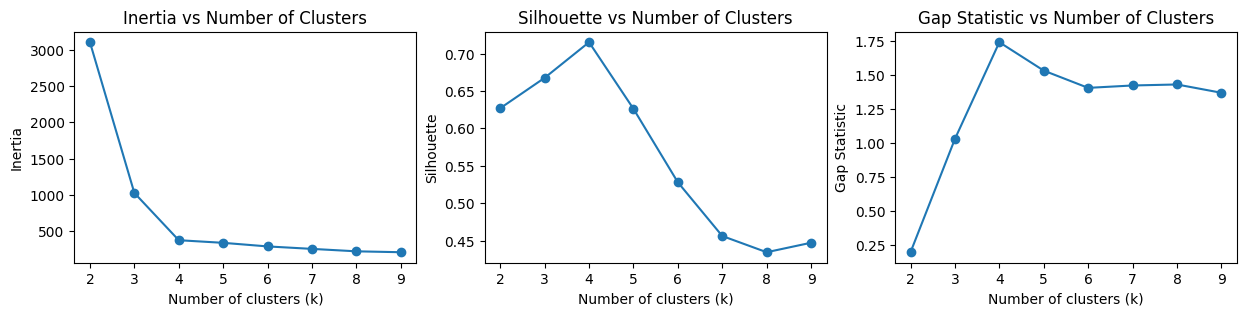

In [85]:
# Choose optimal k
k_range = range(2,10)
inertias = []
silhouettes = []
gap_statistics = []

for k in range(2, 10):
    print(f"k={k}")
    k_means = KMeans(k)
    centroids, labels, scores = k_means.fit(X)
    inertia, silhouette, gap_statistic = scores
    inertias.append(inertia)
    silhouettes.append(silhouette)
    gap_statistics.append(gap_statistic)
    # print(f"k={k}, inertia={inertia}, silhouette={silhouette}, gap_statistic={gap_statistic}") 

plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')

plt.subplot(1, 3, 2)
plt.plot(k_range, silhouettes, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette')
plt.title('Silhouette vs Number of Clusters')

plt.subplot(1, 3, 3)
plt.plot(k_range, gap_statistics, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic vs Number of Clusters')

## K-Means with Sklearn

Sklearn KMeans API reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Parameters:
- n_clusters: int, default=8
- init: {'k-means++', 'random', or an ndarray}
    'k-means++': selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.
    'random': choose k observations (rows) at random from data for the initial centroids.
    If an ndarray is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.
- max_iter: int, default=300
    Maximum number of iterations of the k-means algorithm for a single run.
- n_init: int, default=10
    Number of time the k-means algorithm will be run with different centroid seeds. 
    If an ndarray is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.
- tol: float, default=1e-4
    Relative tolerance with regards to inertia to declare convergence.
- random_state: int, default=None
    Determines random number generation for centroid initialization.
- copy_x: bool, default=True
    If copy_x is True (default), then the original data is not modified.
    If False, the original data is modified, and put back before the function returns, but small numerical differences may be introduced by subtracting and then adding the data mean.
    

Attributes:
- cluster_centers_: ndarray of shape (n_clusters, n_features)
    Coordinates of cluster centers.
- labels_: ndarray of shape (n_samples,)
    Labels of each point.
- inertia_: float
    Sum of squared distances of samples to their closest cluster center.
    

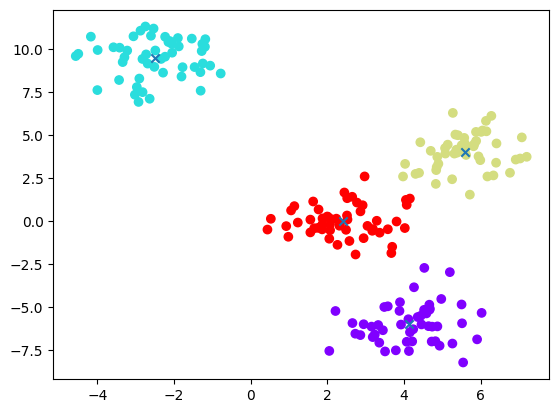

In [92]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=109)
kmeans.fit(X)

# print(kmeans.cluster_centers_)
# print(kmeans.labels_)
# print(kmeans.inertia_)
 
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x')
plt.show()

The new point belongs to cluster 3


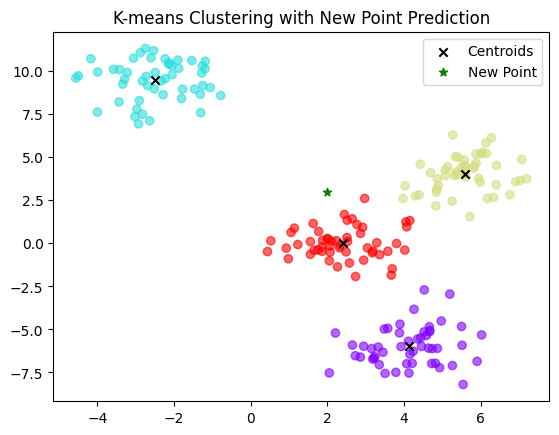

In [94]:
# Prediction on new point
new_point = np.array([[2, 3]])  # Example point, shape must be (n_samples, n_features)

predicted_cluster = kmeans.predict(new_point)
print(f"The new point belongs to cluster {predicted_cluster[0]}")

# Visualize the prediction
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='rainbow', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', color='black', label='Centroids')
plt.scatter(new_point[:,0], new_point[:,1], marker='*', color='green', label='New Point')
plt.legend()
plt.title('K-means Clustering with New Point Prediction')
plt.show()

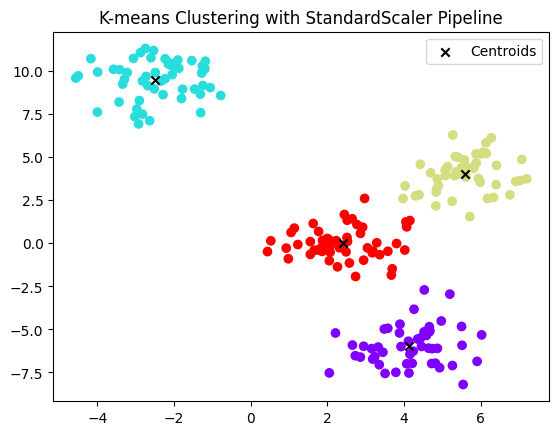

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create a pipeline that combines StandardScaler and KMeans
kmeans_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=109))
])

# Fit the pipeline
kmeans_pipeline.fit(X)


labels = kmeans_pipeline['kmeans'].labels_
scaled_centers = kmeans_pipeline['kmeans'].cluster_centers_
# Inverse transform the centers to get them in original scale 
centers = kmeans_pipeline['scaler'].inverse_transform(scaled_centers)

# Visualize the results
plt.scatter(X[:,0], X[:,1], c=labels, cmap='rainbow')
plt.scatter(centers[:,0], centers[:,1], marker='x', color='black', label='Centroids')
plt.legend()
plt.title('K-means Clustering with StandardScaler Pipeline')
plt.show()